In [1]:
import os
import numpy as np

data_dir = 'plant-disease-archive/raw/color'

os.listdir(data_dir)

['Apple___Cedar_apple_rust', 'Corn_(maize)___healthy', 'Potato___healthy']

In [2]:
import glob
image_names = glob.glob(data_dir + '/*/*.JPG') + glob.glob(data_dir + '/*/*.jpg')

print(len(image_names))

print(type(image_names))

# print(image_names)

477
<class 'list'>


In [3]:
import pandas as pd

# make train_image_names as series object
image_names = pd.Series(image_names)

In [4]:
# train_df: a dataframe with 2 field: Filename, ClassId
train_df = pd.DataFrame()

# generate Filename field
train_df['Filename'] = image_names.map(lambda img_name: img_name.split("/")[-1])

# generate ClassId field
train_df['ClassId'] = image_names.map(lambda img_name: img_name.split("/")[-2])

train_df.head()

Filename                   ClassId
0  025b2b9a-0ec4-4132-96ac-7f2832d0db4a___FREC_C....  Apple___Cedar_apple_rust
1  0321e067-d13b-47d0-b3a6-76ba6f357d02___FREC_C....  Apple___Cedar_apple_rust
2  0340baaa-e9cc-4c04-8f9b-c204180d9ae3___FREC_C....  Apple___Cedar_apple_rust
3  04da297e-5238-41b1-a8a0-0c87c6c2f21f___FREC_C....  Apple___Cedar_apple_rust
4  052e3deb-0499-4685-bc39-cea7f1df0700___FREC_C....  Apple___Cedar_apple_rust

In [5]:
class_id_distribution = train_df['ClassId'].value_counts()
class_id_distribution

Apple___Cedar_apple_rust    275
Potato___healthy            152
Corn_(maize)___healthy       50
Name: ClassId, dtype: int64

<BarContainer object of 3 artists>

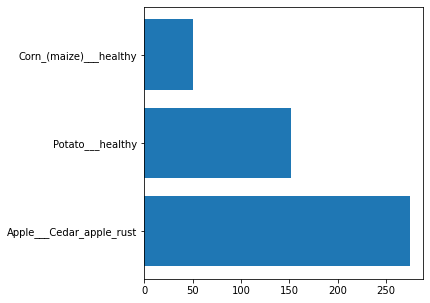

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.barh(class_id_distribution.index, class_id_distribution.values)

# Balanced Data Generator

In [7]:
from keras.utils.data_utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.tensorflow import balanced_batch_generator

In [8]:
class BalancedDataGenerator(Sequence):
    """ImageDataGenerator + RandomOversampling"""
    def __init__(self, x, y, datagen, batch_size=32):
        self.datagen = datagen
        self.batch_size = min(batch_size, x.shape[0])
        datagen.fit(x)
        self.gen, self.steps_per_epoch = balanced_batch_generator(x.reshape(x.shape[0], -1), y, sampler=RandomOverSampler(), batch_size=self.batch_size, keep_sparse=True)
        self._shape = (self.steps_per_epoch * batch_size, *x.shape[1:])
        
    def __len__(self):
        return self.steps_per_epoch

    def __getitem__(self, idx):
        x_batch, y_batch = self.gen.__next__()
        x_batch = x_batch.reshape(-1, *self._shape[1:])
        return self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()

In [9]:
from keras_preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(#preprocessing_function=preprocess_input,
                            rotation_range=20,
                            shear_range=0.1,
                            vertical_flip=True,
                            validation_split=0.2,
                            zoom_range=1.5)

In [10]:
# image_size = 256

# train_gen = datagen.flow_from_directory(
#                                         directory=data_dir,
#                                         target_size=(image_size, image_size),
#                                         batch_size=64,
#                                         class_mode='categorical',
#                                         subset='training',
#                                         seed=42)

# validation_gen = datagen.flow_from_directory(
#                                         directory=data_dir,
#                                         target_size=(image_size, image_size),
#                                         class_mode='categorical',
#                                         subset='validation',
#                                         seed=42)

In [11]:
# print(train_gen.__len__())

In [12]:
# https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/
    
# from imutils import paths
from skimage import io, color
from skimage.transform import resize

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
# imagePaths = list(paths.list_images(data_dir))
data = []
labels = []
# loop over the image paths
for imagePath in image_names:
    # extract the class label from the filename, load the image, and
    # resize it to be a fixed 64x64 pixels, ignoring aspect ratio
    label = imagePath.split(os.path.sep)[-2]
    image = io.imread(imagePath)
    image = resize(image, (64, 64))
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)

[INFO] loading images...


In [13]:
from sklearn.model_selection import train_test_split

(trainX, testX, trainY, testY) = train_test_split(data, labels,
test_size=0.25, random_state=42)

trainX = np.asarray(trainX)
trainY = np.asarray(trainY)

In [14]:
balanced_gen = BalancedDataGenerator(trainX, trainY, datagen, batch_size=64)

In [15]:
steps_per_epoch = balanced_gen.steps_per_epoch

# training_generator, steps_per_epoch = balanced_batch_generator(x, y, sampler=RandomOverSampler(sampling_strategy='minority'), batch_size=8, keep_sparse = True, random_state=42)

# my_generator = ((np.reshape(x, (-1, og_dim_1, og_dim_2)), y) for (x,y) in training_generator)

# callback_history = model.fit_generator(balanced_gen, steps_per_epoch = steps_per_epoch, epochs=100, verbose=0)

In [16]:
item = balanced_gen.__getitem__(0)

y_gen = [item[1]]
balanced_images = [item[0]]

for i in range(1, steps_per_epoch):
    
    item = balanced_gen.__getitem__(0)    
    
    y_gen.append(item[1])
    balanced_images.append(item[0])
    
y_gen = np.concatenate(y_gen)
print(np.unique(y_gen, return_counts=True))

len2 = len(y_gen)
print(len2)

(array(['Apple___Cedar_apple_rust', 'Corn_(maize)___healthy',
       'Potato___healthy'], dtype='<U24'), array([192, 187, 197]))
576


In [17]:
balanced_images = np.concatenate(balanced_images)

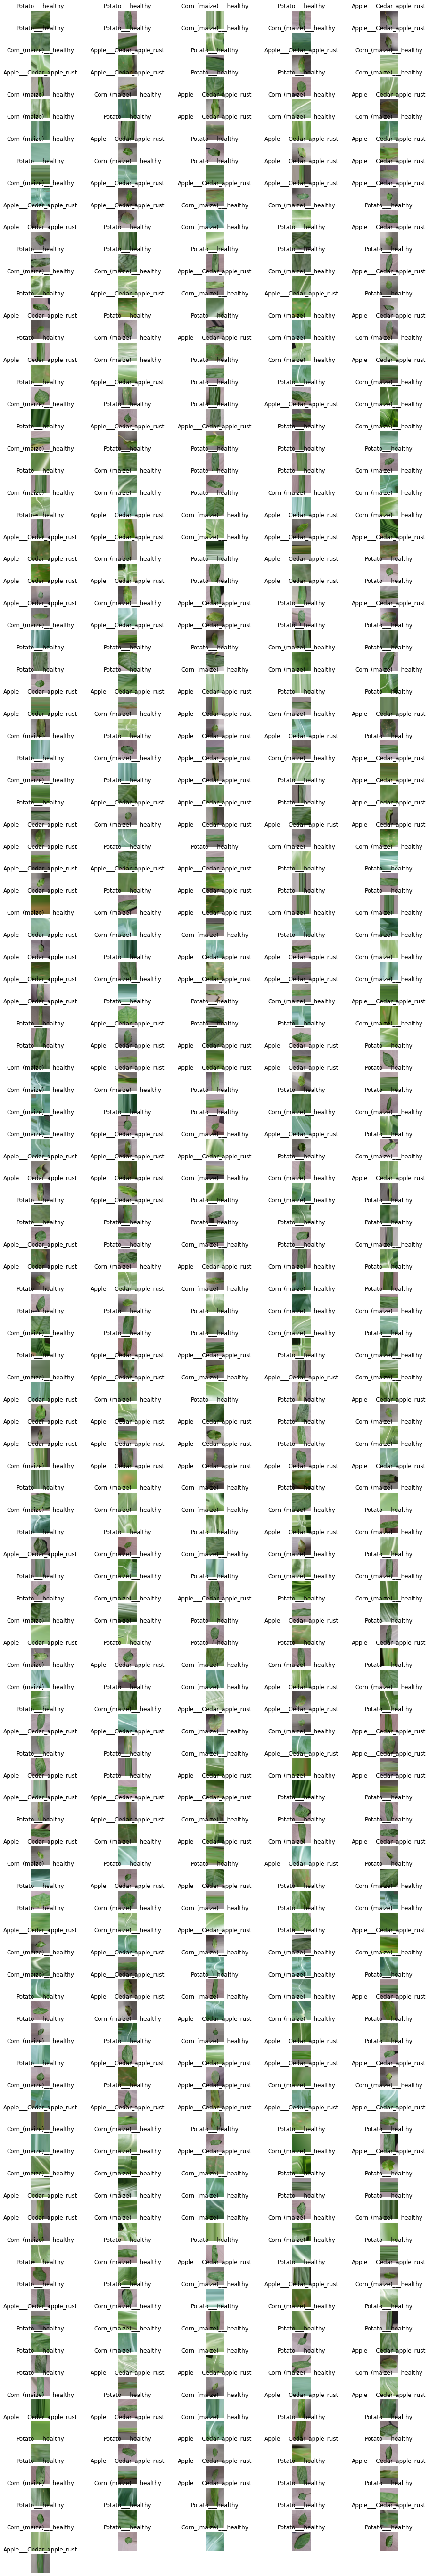

In [18]:
plt.figure(figsize=(16, 100))

for i in range(len2):
    
    plt.subplot((len2+4)//5, 5, i + 1)
    plt.title(y_gen[i])
    plt.imshow(balanced_images[i], cmap='gray')
    plt.axis('off')
    
plt.show()